In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model
tfpl=tfp.layers
tfd=tfp.distributions
import matplotlib.pyplot as plt
import keras.backend as K
# ----------------------------------------------------
import skimage
import skimage.feature
import skimage.viewer
from skimage import color
from skimage.filters import sobel
from skimage import exposure
from skimage.filters import gaussian
from skimage.transform import rotate, rescale
from skimage import img_as_float
from skimage import filters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Viewer requires Qt


In [ ]:
IMAGES_DATA=[]
for label,folder in enumerate(os.listdir('/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/capsnet-keras/Original')):
  for file in os.listdir(f'/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/capsnet-keras/Original/{folder}'):
    img=cv2.imread(f'/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/capsnet-keras/Original/{folder}/{file}')
    img=cv2.resize(img,(128,128))
    IMAGES_DATA.append((img/255.0,label))
IMAGES_DATA=np.array(IMAGES_DATA)

mask_DATA=[]
for label,mask in enumerate(os.listdir('/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Segmented')):
  for mask_file in os.listdir(f'/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Segmented/{mask}'):
    img=cv2.imread(f'/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Segmented/{mask}/{mask_file}')
    img=cv2.resize(img,(128,128))
    mask_DATA.append((np.round(img/255.0),label))
mask_DATA=np.array(mask_DATA)
DATA=np.array([(image,mask,label) for image,mask,label in zip(IMAGES_DATA[:,0],mask_DATA[:,0],IMAGES_DATA[:,1])])
DATA=shuffle(DATA)
IMAGES=np.array([ i for i in DATA[:,0]]).reshape(3256,128,128,3)
MASKS=np.array([ i for i in DATA[:,1]]).reshape(3256,128,128,3)
LABEL=DATA[:,2]
x_train,x_test,x_label,y_label=IMAGES[:2600],IMAGES[2600:],LABEL[:2600],LABEL[2600:]
y_train,y_test=np.round(MASKS[:2600]),np.round(MASKS[2600:])
x_train.shape,x_test.shape,y_train.shape,y_test.shape

In [ ]:
TRAINLABEL_FRAME=pd.DataFrame({
    'y_train':x_label
})
TESTLABEL_FRAME=pd.DataFrame({
    'y_test':y_label
})
TESTLABEL_FRAME.head()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
u=enc.fit_transform(np.array(TRAINLABEL_FRAME['y_train']).reshape(-1,1)).toarray()
TRAINLABEL_FRAME[[ f'{i.split("_")[1]}/{j}' for i,j in zip(enc.get_feature_names(),['Benign','Early','Pre','Pro'])]]=u
TRAINLABEL_FRAME.head()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
u=enc.fit_transform(np.array(TESTLABEL_FRAME['y_test']).reshape(-1,1)).toarray()
TESTLABEL_FRAME[[ f'{i.split("_")[1]}/{j}' for i,j in zip(enc.get_feature_names(),['Benign','Early','Pre','Pro'])]]=u
TESTLABEL_FRAME.head()

In [ ]:
plt.rcParams['figure.figsize']=(10,5)
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.subplot(1,2,2)
plt.imshow(x_train[1])
plt.show()

In [ ]:
import keras.backend as K
plt.rcParams['figure.figsize']=(10,5)
plt.subplot(1,2,1)
plt.imshow(x_train[3])
plt.subplot(1,2,2)
plt.imshow(keras.layers.Multiply()((x_train[3], y_train[3])))
plt.show()

## Model

In [ ]:
Data_augmentation = tf.keras.Sequential([
  keras.layers.Input(shape=(128,128,3)),
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.2),
  keras.layers.RandomTranslation(height_factor=(-0.2,0.3),width_factor=(-0.2,0.3),fill_mode="reflect",
    interpolation="bilinear"),
  keras.layers.RandomZoom(height_factor=(0.2,0.3),width_factor=(0.2,0.3)),
  keras.layers.RandomHeight(0.2, interpolation="bilinear"),
  keras.layers.RandomContrast(0.25)
  ])

In [ ]:
from keras import layers

def double_conv_block(inp, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(inp)
   x=keras.layers.BatchNormalization()(x)
   u=keras.layers.concatenate([inp,x])
   v = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(u)
   v=keras.layers.BatchNormalization()(v)
   x=keras.layers.concatenate([u,v,inp])
   return x
def SE_BLOCK(in_block, ch, ratio=16):
    x = keras.layers.GlobalAveragePooling2D()(in_block)
    x = keras.layers.Dense(ch//ratio,activation='relu')(x)
    x = keras.layers.Dense(ch,activation='sigmoid')(x)
    x = tf.reshape(x, shape=[-1, 1, 1, ch], name='scaler')
    return keras.layers.multiply([in_block, x])

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

## Classifier DAG

In [ ]:
INPUT=keras.layers.Input(shape=(128,128,3))
AUG_1=keras.layers.RandomFlip("horizontal_and_vertical")(INPUT)
AUG_2=keras.layers.RandomRotation(0.2)(AUG_1)

conv_1=keras.layers.Conv2D(8,(3,3),activation='relu',padding='same')(AUG_2)
conv_2=keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(conv_1)
concat_1=keras.layers.concatenate([AUG_2,conv_2])

conv_3=keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(concat_1)
conv_4=keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(conv_3)
concat_3=keras.layers.concatenate([AUG_2,conv_4])
pool_2=keras.layers.AveragePooling2D((2,2))(concat_3)

# drop_out_2=keras.layers.Dropout(0.3)(pool_2)

conv_=keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(pool_2)
pool_=keras.layers.AveragePooling2D((2,2))(conv_)
conv__=keras.layers.Conv2D(4,(3,3),activation='relu',padding='same')(pool_)
pool__=keras.layers.AveragePooling2D((2,2))(conv__)
flat=keras.layers.Flatten()(pool__)
DAG_Classifer=keras.models.Model([INPUT],[flat])

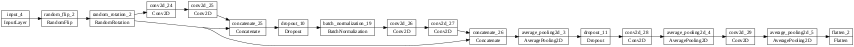

In [ ]:
plot_model(DAG_Classifer,to_file='My_Model.png',rankdir='LR',dpi=25) 

In [ ]:
inputs = layers.Input(shape=(128,128,3))
inp_seblock=SE_BLOCK(inputs,3)
f1, p1 = downsample_block(inp_seblock, 3)
p1_seblock=SE_BLOCK(p1,12)
f2, p2 = downsample_block(p1_seblock, 3)
p2_seblock=SE_BLOCK(p2,30)
f3, p3 = downsample_block(p2_seblock, 3)
p3_seblock=SE_BLOCK(p3,66)
f4, p4 = downsample_block(p3_seblock, 3)
p4_seblock=SE_BLOCK(p4,138)

bottleneck = double_conv_block(p4_seblock, 3)

f4_seblock=SE_BLOCK(f4,138)
u6 = upsample_block(bottleneck, f4_seblock, 3)
f3_seblock=SE_BLOCK(f3,66)
u7 = upsample_block(u6, f3_seblock, 3)
f2_seblock=SE_BLOCK(f2,30)
u8 = upsample_block(u7, f2_seblock, 3)
f1_seblock=SE_BLOCK(f1,12)
u9 = upsample_block(u8, f1_seblock, 3)

def BLAST_CELL_EXTRACTION(inp,mask):
  return keras.layers.Multiply()([inp,tf.math.round(mask)])

MASK = layers.Conv2D(3, 1, padding="same",activation='sigmoid',name='MASK_OUT')(u9)
Extracted_Blst_Cells=BLAST_CELL_EXTRACTION(inputs,MASK)

Main_features=DAG_Classifer(Extracted_Blst_Cells)
Compressed_features=keras.layers.Flatten()(bottleneck)

concatenated_Features=keras.layers.concatenate([Compressed_features,Main_features])
Dense_1=keras.layers.Dense(64,activation='relu')(concatenated_Features)
Dense_2=keras.layers.Dense(32,activation='relu')(Dense_1)
output=keras.layers.Dense(4,activation='softmax',name='Class_OUT')(Dense_2)
Full_Functional_DAG_Network = tf.keras.Model([inputs], [MASK,output], name="U-Net")

In [ ]:
inputs = layers.Input(shape=(128,128,3))
inp_seblock=SE_BLOCK(inputs,3)
f1, p1 = downsample_block(inp_seblock, 3)
p1_seblock=SE_BLOCK(p1,12)
f2, p2 = downsample_block(p1_seblock, 3)
p2_seblock=SE_BLOCK(p2,30)
f3, p3 = downsample_block(p2_seblock, 3)
p3_seblock=SE_BLOCK(p3,66)
f4, p4 = downsample_block(p3_seblock, 3)
p4_seblock=SE_BLOCK(p4,138)

bottleneck = double_conv_block(p4_seblock, 3)

f4_seblock=SE_BLOCK(f4,138)
u6 = upsample_block(bottleneck, f4_seblock, 3)
f3_seblock=SE_BLOCK(f3,66)
u7 = upsample_block(u6, f3_seblock, 3)
f2_seblock=SE_BLOCK(f2,30)
u8 = upsample_block(u7, f2_seblock, 3)
f1_seblock=SE_BLOCK(f1,12)
u9 = upsample_block(u8, f1_seblock, 3)

def BLAST_CELL_EXTRACTION(inp,mask):
  return keras.layers.Multiply()([inp,tf.math.round(mask)])

MASK = layers.Conv2D(3, 1, padding="same",activation='sigmoid',name='MASK_OUT')(u9)
Extracted_Blst_Cells=BLAST_CELL_EXTRACTION(inputs,MASK)

inp_seblock_=SE_BLOCK(Extracted_Blst_Cells,3)
f1_, p1_ = downsample_block(inp_seblock_, 3)
p1_=keras.layers.concatenate([p1_,p1])
p1_seblock_=SE_BLOCK(p1_,24)
f2_, p2_ = downsample_block(p1_seblock, 3)
p2_=keras.layers.concatenate([p2_,p2])
p2_seblock_=SE_BLOCK(p2_,60)
f3_, p3_ = downsample_block(p2_seblock_, 3)
p3_=keras.layers.concatenate([p3_,p3])
p3_seblock_=SE_BLOCK(p3_,192)
f4_, p4_ = downsample_block(p3_seblock, 3)
p4_=keras.layers.concatenate([p4_,p4])
p4_seblock_=SE_BLOCK(p4_,276)

bottleneck_ = double_conv_block(p4_seblock_, 3)

concatenated_Features=keras.layers.concatenate([bottleneck_,bottleneck])
f4_, p4_ = downsample_block(concatenated_Features, 8)
flat=keras.layers.Flatten()(p4_)
Dense_1=keras.layers.Dense(64,activation='relu')(flat)
Dense_2=keras.layers.Dense(32,activation='relu')(Dense_1)
output=keras.layers.Dense(4,activation='softmax',name='Class_OUT')(Dense_2)
Full_Functional_DAG_Network = tf.keras.Model([inputs], [MASK,output], name="U-Net")

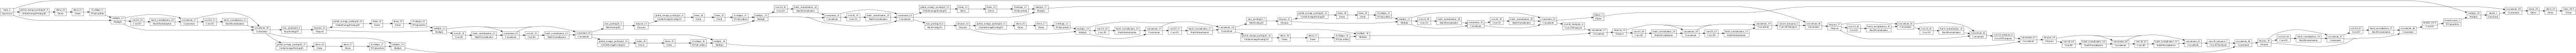

In [ ]:
plot_model(Full_Functional_DAG_Network,to_file='My_Model_DAG.png',rankdir='LR',dpi=25) 

In [ ]:
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


Full_Functional_DAG_Network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss=  {
                      'MASK_OUT':'binary_crossentropy',
                      'Class_OUT':'sparse_categorical_crossentropy'
                         },
                  metrics=       
                      {'MASK_OUT':[dice_coef,keras.metrics.Recall()],
                      'Class_OUT':['accuracy']}
                                  
                              )  


In [ ]:
Full_Functional_DAG_Network.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 global_average_pooling2d_9 (Gl  (None, 3)           0           ['input_5[0][0]']                
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_20 (Dense)               (None, 0)            0           ['global_average_pooling2d_9[0][0
                                                                 ]']                          

In [ ]:
model_history = Full_Functional_DAG_Network.fit(x_train,
                  [y_train,np.array(TRAINLABEL_FRAME['y_train'].values,dtype=np.float)],
                  epochs=25)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Epoch 1/250
70/70 [==============================] - 33s 174ms/step - loss: 1.7313 - MASK_OUT_loss: 0.2152 - Class_OUT_loss: 1.5161 - MASK_OUT_dice_coef: 0.3407 - MASK_OUT_recall_1: 0.4527 - Class_OUT_accuracy: 0.6480 - val_loss: 5.6684 - val_MASK_OUT_loss: 0.2050 - val_Class_OUT_loss: 5.4634 - val_MASK_OUT_dice_coef: 0.0877 - val_MASK_OUT_recall_1: 0.0000e+00 - val_Class_OUT_accuracy: 0.2513
Epoch 2/250
70/70 [==============================] - 9s 123ms/step - loss: 0.6015 - MASK_OUT_loss: 0.1130 - Class_OUT_loss: 0.4885 - MASK_OUT_dice_coef: 0.4662 - MASK_OUT_recall_1: 0.5004 - Class_OUT_accuracy: 0.7873 - val_loss: 8.9763 - val_MASK_OUT_loss: 0.2431 - val_Class_OUT_loss: 8.7332 - val_MASK_OUT_dice_coef: 0.0489 - val_MASK_OUT_recall_1: 0.0000e+00 - val_Class_OUT_accuracy: 0.2513
Epoch 3/250
70/70 [==============================] - 9s 124ms/step - loss: 0.5081 - MASK_OUT_loss: 0.0944 - Class_OUT_loss: 0.4137 - MASK_OUT_dice_coef: 0.5551 - MASK_OUT_recall_1: 0.5925 - Class_OUT_accuracy:

21/21 [==============================] - 1s 59ms/step - loss: 5.8296 - MASK_OUT_loss: 0.5196 - Class_OUT_loss: 5.3100 - MASK_OUT_dice_coef: 0.4053 - MASK_OUT_recall_1: 0.9416 - Class_OUT_accuracy: 0.6189
[5.8296051025390625, 0.5195883512496948, 5.310017108917236, 0.4053395688533783, 0.9415887594223022, 0.6189024448394775]


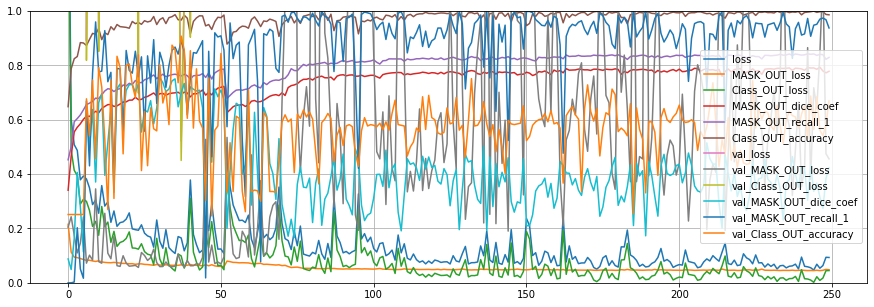

In [ ]:
print(Full_Functional_DAG_Network.evaluate(
    tf.convert_to_tensor(x_test,dtype=tf.float32),
[y_test,tf.convert_to_tensor(TESTLABEL_FRAME['y_test'].values,dtype=tf.float32)] 
                            ))
plt.rcParams['figure.figsize']=(15,5)
pd.DataFrame(model_history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

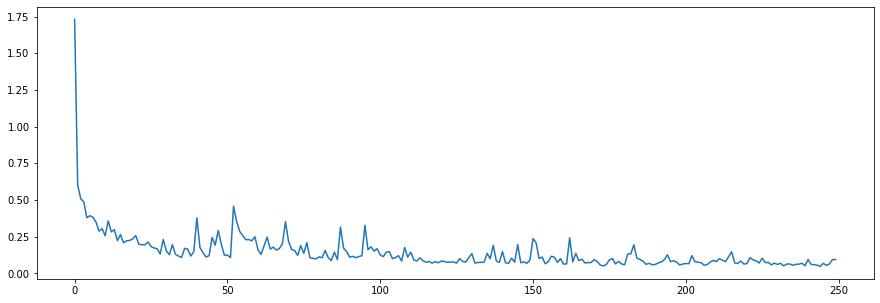

In [ ]:
plt.plot(model_history.history['loss'])

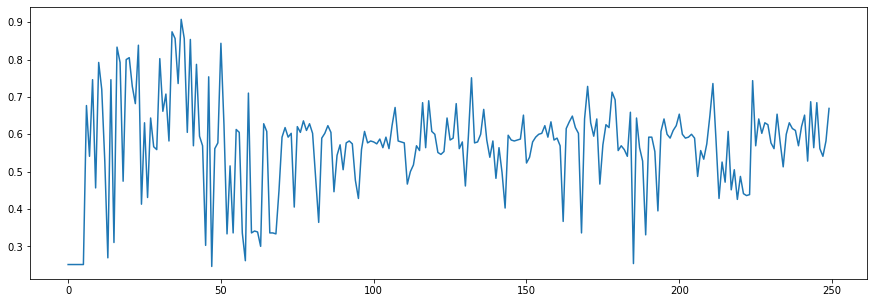

In [ ]:
plt.plot(model_history.history['val_Class_OUT_accuracy'])

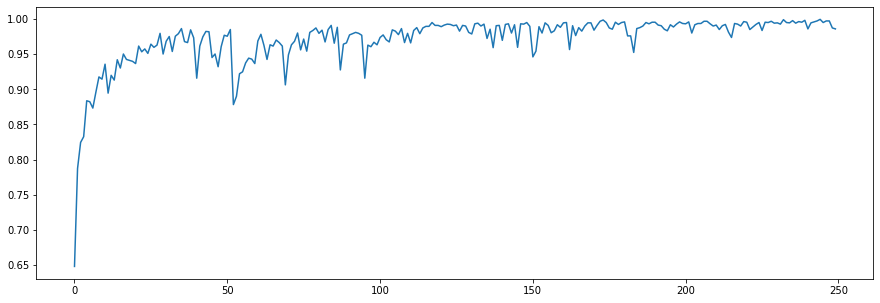

In [ ]:
plt.plot(model_history.history['Class_OUT_accuracy'])

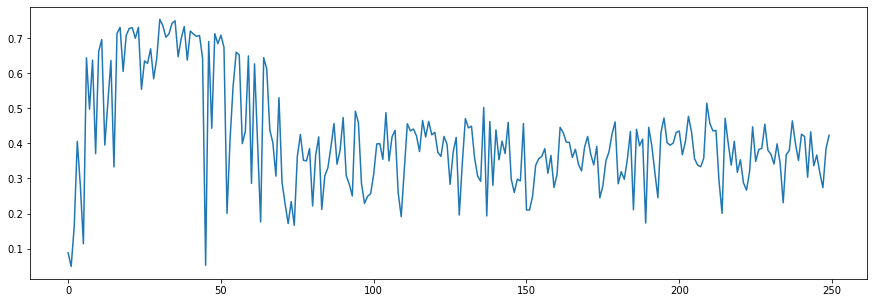

In [ ]:
plt.plot(model_history.history['val_MASK_OUT_dice_coef'])

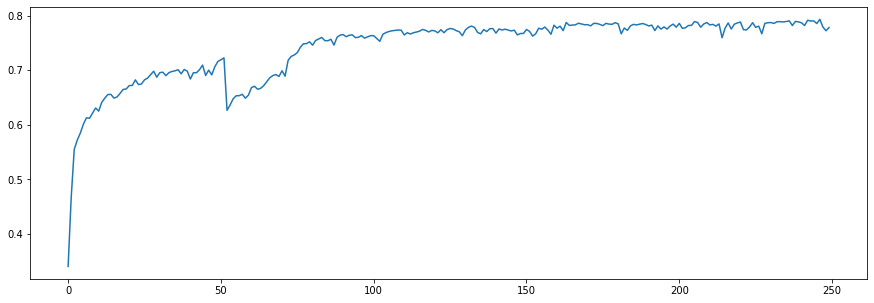

In [ ]:
plt.plot(model_history.history['MASK_OUT_dice_coef'])

In [ ]:
preds=Full_Functional_DAG_Network.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.array(TESTLABEL_FRAME['y_test'].values,dtype=np.float),np.round(preds[1]).argmax(axis=1).astype('float32')
))

              precision    recall  f1-score   support

         0.0       0.52      0.31      0.39        99
         1.0       0.48      0.89      0.63       190
         2.0       1.00      0.17      0.30       208
         3.0       0.75      1.00      0.86       159

    accuracy                           0.60       656
   macro avg       0.69      0.59      0.54       656
weighted avg       0.72      0.60      0.54       656



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


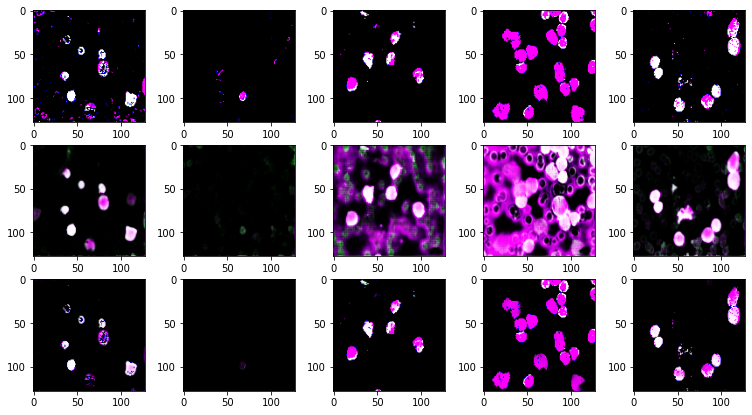

In [ ]:
plt.rcParams['figure.figsize']=(13,7)
for i in range(1,6):
  plt.subplot(3,5,i)
  plt.imshow(y_test[i])
  plt.subplot(3,5,i+5)
  plt.imshow(preds[0][i])
  plt.subplot(3,5,i+10)
  plt.imshow(y_test[i]*preds[0][i])
plt.show()

## Simple Model

In [ ]:
INPUT=keras.layers.Input(shape=(128,128,3))
AUG_1=keras.layers.RandomFlip("horizontal_and_vertical")(INPUT)
AUG_2=keras.layers.RandomRotation(0.2)(AUG_1)
AUG_3=keras.layers.RandomContrast(0.2)(AUG_2)
CON_1=keras.layers.Conv2D(8,(3,3),activation='relu',padding='same')(AUG_3)
CON_2=keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(CON_1)
pool_1=keras.layers.AveragePooling2D((2,2))(CON_2)
BN_1=keras.layers.BatchNormalization()(pool_1)
Dropout_1=keras.layers.Dropout(0.3)(BN_1)
CON_3=keras.layers.Conv2D(8,(3,3),activation='relu',padding='same')(Dropout_1)
CON_4=keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(CON_3)
pool_2=keras.layers.AveragePooling2D((2,2))(CON_4)
BN_1=keras.layers.BatchNormalization()(pool_2)
Dropout_2=keras.layers.Dropout(0.3)(BN_1)
CON_5=keras.layers.Conv2D(8,(3,3),activation='relu',padding='same')(Dropout_2)
CON_6=keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(CON_5)
pool_3=keras.layers.AveragePooling2D((2,2))(CON_6)
CON_7=keras.layers.Conv2D(8,(3,3),activation='relu',padding='same')(pool_3)
CON_8=keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(CON_7)
pool_4=keras.layers.AveragePooling2D((2,2))(CON_6)

dense_1=keras.layers.Dense(16,activation='relu')(keras.layers.Flatten()(pool_4))
dense_2=keras.layers.Dense(16,activation='relu')(keras.layers.Flatten()(pool_3))
dense_3=keras.layers.Dense(16,activation='relu')(keras.layers.Flatten()(pool_2))
dense_4=keras.layers.Dense(16,activation='relu')(keras.layers.Flatten()(pool_1))
Hub=keras.layers.concatenate([dense_1,dense_2,dense_3,dense_4])
dense__=keras.layers.Dense(64,activation='relu')(Hub)
bn_1=keras.layers.BatchNormalization()(dense__)
drop_out=keras.layers.Dropout(0.3)(bn_1)
dense_=keras.layers.Dense(32,activation='relu')(drop_out)
output=keras.layers.Dense(4,activation='softmax')(dense_)
BT_Model=keras.models.Model([INPUT],[output])

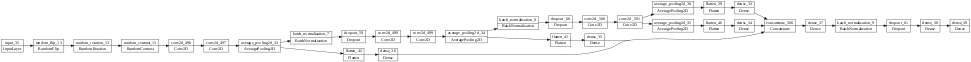

In [ ]:
plot_model(BT_Model,to_file='My_Model.png',rankdir='LR',dpi=20) # 

In [ ]:
BT_Model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip_13 (RandomFlip)    (None, 128, 128, 3)  0           ['input_35[0][0]']               
                                                                                                  
 random_rotation_13 (RandomRota  (None, 128, 128, 3)  0          ['random_flip_13[0][0]']         
 tion)                                                                                            
                                                                                           

In [ ]:
BT_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
hist=BT_Model.fit( tf.convert_to_tensor(x_train,dtype=tf.float32),
   tf.convert_to_tensor(TRAINLABEL_FRAME['y_train'].values,dtype=tf.float32),epochs=20,validation_split=0.15)

Epoch 1/20
67/67 [==============================] - 58s 806ms/step - loss: 0.9080 - accuracy: 0.6485 - val_loss: 8.4219 - val_accuracy: 0.2773
Epoch 2/20
67/67 [==============================] - 54s 802ms/step - loss: 0.4550 - accuracy: 0.8489 - val_loss: 6.7620 - val_accuracy: 0.2587
Epoch 3/20
13/67 [====>.........................] - ETA: 41s - loss: 0.3631 - accuracy: 0.8726

KeyboardInterrupt: ignored

21/21 [==============================] - 5s 250ms/step - loss: 0.4258 - Accuracy: 0.8460
[0.4257813096046448, 0.8460366129875183]


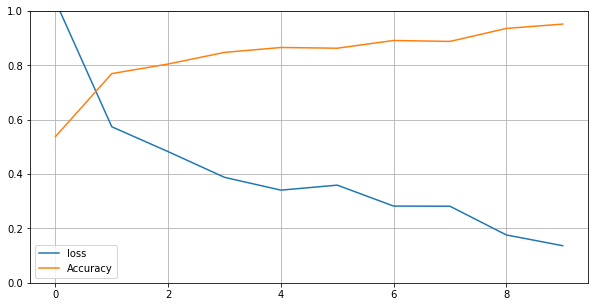

In [ ]:
print(BT_Model.evaluate(tf.convert_to_tensor(x_test,dtype=tf.float32),
                  tf.convert_to_tensor(y_test,dtype=tf.float32)))
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
preds=Model.predict(x_test)
print(classification_report(np.array(y_test,dtype=np.int64),np.round(preds).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59       106
           1       0.83      0.81      0.82       189
           2       0.91      0.94      0.92       208
           3       0.98      0.99      0.99       153

    accuracy                           0.86       656
   macro avg       0.83      0.83      0.83       656
weighted avg       0.85      0.86      0.85       656



In [ ]:
c=np.array([[1, 3, 0, 0, 3],
            [1, 3, 1, 0, 2],
            [1, 3, 1, 2, 2]])
c = tf.constant(c)
tf.map_fn(lambda x: tf.unique_with_counts(x).y[tf.argmax(tf.unique_with_counts(x).count, 
                                                         output_type=tf.int32)], tf.transpose(c))


Experiments

In [ ]:
def PROBABILISTIC_CONV_LAYER(filters,size):
  return keras.layers.Conv2D(filters,size,activation='relu',padding='same')
INPUT=keras.layers.Input(shape=(128,128,3))
Aumentation=Data_augmentation(INPUT)
Res_Block_1=Hyper_Residuary_Bloc(Aumentation,8)
Res_Block_2=Hyper_Residuary_Bloc(Res_Block_1,16)
Res_Block_3=Hyper_Residuary_Bloc(Res_Block_2,16)
Res_Block_4=Hyper_Residuary_Bloc(Res_Block_3,32)
Res_Block_5=Hyper_Residuary_Bloc(Res_Block_4,32)
Res_Block_6=Hyper_Residuary_Bloc(Res_Block_5,64)
incp_3=Complex_Incept_Block(Res_Block_6,8,16,32)
GP=keras.layers.GlobalAveragePooling2D()(incp_3)
flat=keras.layers.Flatten()(GP)
dense_1=keras.layers.Dense(64,activation='relu')(flat)
output=keras.layers.Dense(4,activation='softmax')(dense_1)
BI_DAG_Model=keras.models.Model([INPUT],[output])

BI_DAG_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.05),loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
hist=BI_DAG_Model.fit( tf.convert_to_tensor(x_train,dtype=tf.float32),
   tf.convert_to_tensor(TRAINLABEL_FRAME['y_train'].values,dtype=tf.float32),
   epochs=30)

In [ ]:
def PROBABILISTIC_CONV_LAYER(filters,size):
  return keras.layers.Conv2D(filters,size,activation='relu',padding='same')

def Hyper_Residuary_Bloc(inp, n_filters):
   a = PROBABILISTIC_CONV_LAYER(n_filters,(1,1))(inp)
   b= PROBABILISTIC_CONV_LAYER(n_filters,(3,3))(a)
   c= PROBABILISTIC_CONV_LAYER(n_filters,(5,5))(a)
   concat=keras.layers.concatenate([a,b,c])
   x = PROBABILISTIC_CONV_LAYER(1,(3,3))(keras.layers.concatenate([concat,c,a]))
   return x

def Complex_Incept_Block(layer_in, f1, f2,f3):
	conv1 = PROBABILISTIC_CONV_LAYER(f1,(1,1))(layer_in)
	conv3 = PROBABILISTIC_CONV_LAYER(f2,(3,3))(layer_in)
	conv5 = PROBABILISTIC_CONV_LAYER(f3,(5,5))(layer_in)
	pool = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	layer_out = keras.layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out
tfd=tfp.distributions
tfpl=tfp.layers

def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution

def get_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size+bias_size  
    prior_model = keras.models.Sequential([tfpl.DistributionLambda(lambda t : spike_and_slab(n, dtype))])
    return prior_model
def get_posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return keras.models.Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n)
    ])

In [ ]:
INPUT=keras.layers.Input(shape=(128,128,3))
AUG_1=keras.layers.RandomFlip("horizontal_and_vertical")(INPUT)
AUG_2=keras.layers.RandomRotation(0.2)(AUG_1)
AUG_3=keras.layers.RandomContrast(0.2)(AUG_2)
Res_Block_1=Hyper_Residuary_Bloc(AUG_3,8)
Res_Block_2_a=Hyper_Residuary_Bloc(Res_Block_1,8)
Res_Block_2_b=Hyper_Residuary_Bloc(Res_Block_1,8)

Res_Block_3_a=Hyper_Residuary_Bloc(Res_Block_2_a,8)
Res_Block_3_b=Hyper_Residuary_Bloc(Res_Block_2_a,8)
Res_Block_3_c=Hyper_Residuary_Bloc(Res_Block_2_b,8)
Res_Block_3_d=Hyper_Residuary_Bloc(Res_Block_2_b,8)

Res_Block_4_a=Hyper_Residuary_Bloc(Res_Block_3_a,8)
Res_Block_4_b=Hyper_Residuary_Bloc(Res_Block_3_a,8)
Res_Block_4_c=Hyper_Residuary_Bloc(Res_Block_3_b,8)
Res_Block_4_d=Hyper_Residuary_Bloc(Res_Block_3_b,8)
Res_Block_4_e=Hyper_Residuary_Bloc(Res_Block_3_c,8)
Res_Block_4_f=Hyper_Residuary_Bloc(Res_Block_3_c,8)
Res_Block_4_g=Hyper_Residuary_Bloc(Res_Block_3_d,8)
Res_Block_4_h=Hyper_Residuary_Bloc(Res_Block_3_d,8)

Add_3=keras.layers.concatenate([Res_Block_4_a,Res_Block_4_b,Res_Block_4_c,Res_Block_4_d,
                                Res_Block_4_e,Res_Block_4_f,
                        Res_Block_4_g,Res_Block_4_h])

drop_4=keras.layers.Dropout(0.4)(Add_3)
last_conv=PROBABILISTIC_CONV_LAYER(3,(3,3))(drop_4)
last_global_pool=keras.layers.AveragePooling2D((2,2))(last_conv)
flat=keras.layers.Flatten()(last_global_pool)
var_1=tfpl.DenseVariational(units=16, make_posterior_fn=get_posterior,
                            make_prior_fn=get_prior, kl_weight=1/2600.0)(flat)
var_2=tfpl.DenseVariational(units=8, make_posterior_fn=get_posterior, 
                            make_prior_fn=get_prior, kl_weight=1/2600.0)(var_1)

dense_Network=tfp.layers.DenseReparameterization(
      units=tfp.layers.OneHotCategorical.params_size(4), activation=None,
      kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
      kernel_divergence_fn = Approx_divergence_fn,
      bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
      bias_divergence_fn = Approx_divergence_fn)(flat)
output=tfp.layers.OneHotCategorical(4)(dense_Network)
BI_DAG_Model=keras.models.Model([INPUT],[output])

In [ ]:
inputs = layers.Input(shape=(128,128,3))
inp_seblock=SE_BLOCK(inputs,3)
f1, p1 = downsample_block(inp_seblock, 3)
p1_seblock=SE_BLOCK(p1,12)
f2, p2 = downsample_block(p1_seblock, 3)
p2_seblock=SE_BLOCK(p2,30)
f3, p3 = downsample_block(p2_seblock, 3)
p3_seblock=SE_BLOCK(p3,66)
f4, p4 = downsample_block(p3_seblock, 3)
p4_seblock=SE_BLOCK(p4,138)

bottleneck = double_conv_block(p4_seblock, 3)

f4_seblock=SE_BLOCK(f4,138)
u6 = upsample_block(bottleneck, f4_seblock, 3)
f3_seblock=SE_BLOCK(f3,66)
u7 = upsample_block(u6, f3_seblock, 3)
f2_seblock=SE_BLOCK(f2,30)
u8 = upsample_block(u7, f2_seblock, 3)
f1_seblock=SE_BLOCK(f1,12)
u9 = upsample_block(u8, f1_seblock, 3)

def BLAST_CELL_EXTRACTION(inp,mask):
  return keras.layers.Multiply()([inp,tf.math.round(mask)])

MASK = layers.Conv2D(3, 1, padding="same",activation='sigmoid',name='MASK_OUT')(u9)
Extracted_Blst_Cells=BLAST_CELL_EXTRACTION(inputs,MASK)

inp_seblock_=SE_BLOCK(Extracted_Blst_Cells,3)
f1_, p1_ = downsample_block(inp_seblock_, 3)
p1_=keras.layers.concatenate([p1_,p1])
p1_seblock_=SE_BLOCK(p1_,24)
f2_, p2_ = downsample_block(p1_seblock, 3)
p2_=keras.layers.concatenate([p2_,p2])
p2_seblock_=SE_BLOCK(p2_,60)
f3_, p3_ = downsample_block(p2_seblock_, 3)
p3_=keras.layers.concatenate([p3_,p3])
p3_seblock_=SE_BLOCK(p3_,192)
f4_, p4_ = downsample_block(p3_seblock, 3)
p4_=keras.layers.concatenate([p4_,p4])
p4_seblock_=SE_BLOCK(p4_,276)

bottleneck_ = double_conv_block(p4_seblock_, 3)

concatenated_Features=keras.layers.concatenate([bottleneck_,bottleneck])
f4_, p4_ = downsample_block(concatenated_Features, 8)
flat=keras.layers.Flatten()(p4_)
Dense_1=keras.layers.Dense(64,activation='relu')(flat)
Dense_2=keras.layers.Dense(32,activation='relu')(Dense_1)
output=keras.layers.Dense(4,activation='softmax',name='Class_OUT')(Dense_2)
Full_Functional_DAG_Network = tf.keras.Model([inputs], [MASK,output], name="U-Net")

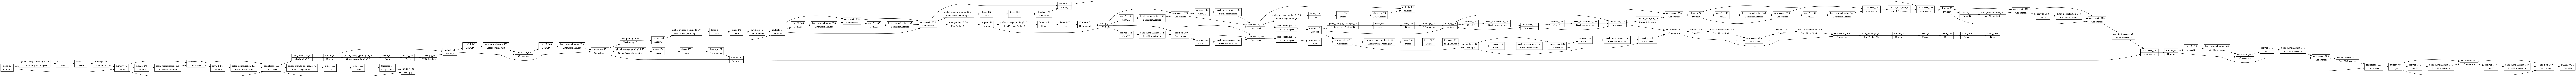

In [ ]:
plot_model(Full_Functional_DAG_Network,rankdir='LR')